In [1]:
import numpy as np
import pandas as pd
from pandas.errors import ParserError
import os
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
import datetime
import random
from itertools import accumulate

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def load_dataset_from_file(file):
    directory = "/kaggle/input/stock-market-data/stock_market_data/nasdaq/csv"
    stock_data = pd.read_csv(directory + '/' + file)
    stock_data.dropna(axis='index', inplace=True)
    stock_data['Date'] = pd.to_datetime(stock_data['Date'], dayfirst=True)
    stock_data['Token'] = file.removesuffix(".csv")
    return stock_data

def load_dataset(token):
    try:
        return load_dataset_from_file(f"{token}.csv")
    except FileNotFoundError:
        print(f"File '{token}.csv' does not exist")
        return None

# Date: 1997-05-15 --- 2022-12-12
def csv_nasdaq_datasets():
    directory = "/kaggle/input/stock-market-data/stock_market_data/nasdaq/csv"
    files = [f for f in os.listdir(directory)]
    random.shuffle(files)
    for file in files:
        try:
            yield load_dataset_from_file(file)
            
        except ParserError:
            print(f"File '{file}' has incorrect format")
            continue
            
def filter_invalid(sets, min_length=100):
    def has_zeros(column):
        return np.count_nonzero(np.array(column) == 0) > 0
    
    for s in sets:
        if len(s) < min_length:
            continue
        if has_zeros(s['Open']) or has_zeros(s['Close']) or has_zeros(s['High']) \
            or has_zeros(s['Low']) or has_zeros(s['Volume']):
            continue
        yield s
        
def only_before(sets, timestamp, min_length=100):
    for s in sets:
        result = s[s['Date'] < timestamp]
        if len(result) < min_length:
            continue
        yield result
        
def only_after(sets, timestamp, min_length=100):
    for s in sets:
        result = s[s['Date'] >= timestamp]
        if len(result) < min_length:
            continue
        yield result

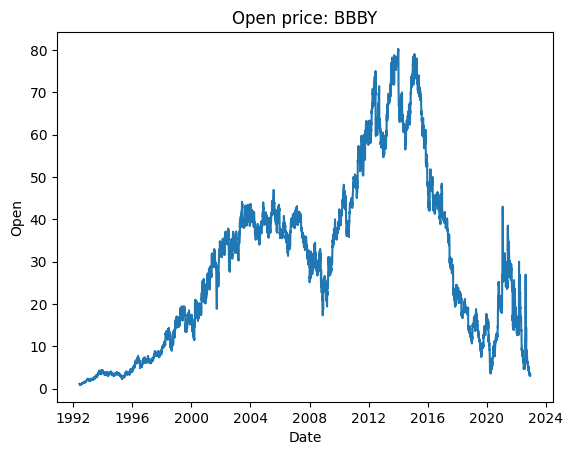

In [3]:
def plot_open(dataset):
    plt.plot(dataset["Date"], dataset["Open"])
    plt.xlabel("Date")
    plt.ylabel("Open")
    plt.title(f"Open price: {dataset['Token'].iloc[0]}")
    plt.show()

stock_data = load_dataset("BBBY")
plot_open(stock_data)

In [4]:
class Scaler:
    def __init__(self, min_output=0, max_output=1):
        if max_output - min_output <= 0:
            raise ValueError("'max_output' must be bigger than 'min_output'")
        
        self._eps = 1e-9
        self._min = min_output
        self._max = max_output
        self._min_input = None
        self._max_input = None
        
    def fit(self, data):
        min_v = min(data)
        max_v = max(data)
        self._min_input = min_v \
            if self._min_input is None or self._min_input > min_v \
            else self._min_input
        self._max_input = max_v \
            if self._max_input is None or self._max_input < max_v \
            else self._max_input
        
    def scale(self, data):
        return (data - self._min_input) / (self._max_input - self._min_input + self._eps) \
                * (self._max - self._min) + self._min 
    
    def descale(self, data):
        return (data - self._min) / (self._max - self._min) \
                * (self._max_input - self._min_input + self._eps) + self._min_input
    
    def get_range(self):
        return self._min_input, self._max_input

In [5]:
class Features:
    def __init__(self, data):
        self.open = np.array(data["Open"].pct_change()[1:])
        self.close = np.array(data["Close"].pct_change()[1:])
        self.high = np.array(data["High"].pct_change()[1:])
        self.low = np.array(data["Low"].pct_change()[1:])
        self.volume = np.array(data["Volume"])[1:]
        self.day_of_week = (np.array(data["Date"].dt.dayofweek) / 6)[1:]
        self.day_of_year_sin = np.sin(2* np.pi * data["Date"].dt.dayofyear / 366)[1:]
        self.day_of_year_cos = np.cos(2* np.pi * data["Date"].dt.dayofyear / 366)[1:]

In [6]:
class FeatureEncoder:
    def __init__(self):
        self._open_scaler = Scaler(0, 1)
        self._close_scaler = Scaler(0, 1)
        self._high_scaler = Scaler(0, 1)
        self._low_scaler = Scaler(0, 1)
        self._volume_scaler = Scaler(0, 1)
        
    def fit(self, data):
        features = Features(data)
        self._open_scaler.fit(features.open)
        self._close_scaler.fit(features.close)
        self._high_scaler.fit(features.high)
        self._low_scaler.fit(features.low)
        self._volume_scaler.fit(features.volume)
    
    def encode(self, data):
        """
        Dataset => 2D array with features
        """
        features = Features(data)
        return np.column_stack((
            self._open_scaler.scale(features.open),
            self._close_scaler.scale(features.close),
            self._high_scaler.scale(features.high),
            self._low_scaler.scale(features.low),
            self._volume_scaler.scale(features.volume),
            features.day_of_week,
            features.day_of_year_sin,
            features.day_of_year_cos
        ))
        
    def decode(self, outputs):
        """
        Nx3 array with predicted values => Nx3 array with close/high/low %-changes
        """
        result = outputs.copy()
        result[:,0] = self._close_scaler.descale(result[:,0])
        result[:,1] = self._high_scaler.descale(result[:,1])
        result[:,2] = self._low_scaler.descale(result[:,2])
        
        return result
    
    def print_scaler_ranges(self):
        print(f"Open: {self._open_scaler.get_range()}")
        print(f"Close: {self._close_scaler.get_range()}")
        print(f"High: {self._high_scaler.get_range()}")
        print(f"Low: {self._low_scaler.get_range()}")
        print(f"Volume: {self._volume_scaler.get_range()}")

In [7]:
def series_to_lstm_inputs(data, n_in=1, n_out=1):
    """
    Convert a time series into sequences used as LSTM inputs and their corresponding outputs.
    Arguments:
        data: Sequence of observations as a list or 2D Numpy array.
        n_in: Number of observations in each LSTM sequence (x).
        n_out: Number of future observations as target LSTM output (y).
    Returns:
        x, y
    """
    x, y = [], []
    for i in range(len(data) - n_in - n_out + 1):
        x.append(data[i:(i+n_in), :])
        y.append(data[i + n_in:i + n_in + n_out, 1:4].flatten()) # columns 1 to 3 => 'Close', 'High' and 'Low' 
    
    return np.array(x), np.array(y)

def divide_into_sets(features, trim=0.1, periods=5, test_size=0.2):
    data = features[int(len(features) * trim):int(len(features) * (1 - trim))]
    batch_size = len(data) // periods
    test = []
    train = []
    for i in range(periods):
        batch = data[batch_size * i:batch_size * (i+1)]
        train.append(batch[:int(batch_size * (1 - test_size))])
        test.append(batch[int(batch_size * (1 - test_size)):])
        
    return train, test

def sets_to_inputs(train_sets, test_sets, days_in=5, days_out=1):
    train_x = []
    train_y = []
    for train_set in train_sets:
        x, y = series_to_lstm_inputs(train_set, days_in, days_out)
        train_x.extend(x)
        train_y.extend(y)

    test_x = []
    test_y = []
    for test_set in test_sets:
        x, y = series_to_lstm_inputs(test_set, days_in, days_out)
        test_x.extend(x)
        test_y.extend(y)
    
    return np.array(train_x), np.array(train_y), np.array(test_x), np.array(test_y)

In [8]:
def load_datasets(number, training_limit='2022-06-12'):
    datasets = [s for _, s in zip(range(number), filter_invalid(csv_nasdaq_datasets()))]
    train_datasets = {s["Token"].iloc[0]: s for s in only_before(datasets, training_limit)}
    validation_datasets = {s["Token"].iloc[0]: s for s in only_after(datasets, training_limit)}
    return train_datasets, validation_datasets

In [9]:
def datasets_to_training_data(datasets, days_in, days_out):    
    encoder = FeatureEncoder()
    for _, dataset in datasets.items():
        encoder.fit(dataset)
        
    train_sets = []
    test_sets = []
    
    for token, dataset in datasets.items():
        features = encoder.encode(dataset)
        nan_count = np.count_nonzero(np.isnan(features))
        if nan_count > 0:
            print(f"NaNs in {token}: {nan_count}")
            continue
        train, test = divide_into_sets(features)
        train_sets.extend(train)
        test_sets.extend(test)
        
    return *sets_to_inputs(train_sets, test_sets, days_in, days_out), encoder

def datasets_to_validation_data(datasets, days_in, days_out, encoder):
    features_sets = []
    for token, dataset in datasets.items():
        features = encoder.encode(dataset)
        nan_count = np.count_nonzero(np.isnan(features))
        if nan_count > 0:
            print(f"NaNs in {token}: {nan_count}")
            continue
        features_sets.append(features)
    _, _, x, y = sets_to_inputs([], features_sets, days_in, days_out)
    return x, y

In [10]:
def make_model(days_in, days_out, show=False):
    model = Sequential()
    model.add(LSTM(256, input_shape=(days_in, 8), return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
    model.add(BatchNormalization())
    model.add(LSTM(256, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
    model.add(BatchNormalization())
    model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(3 * days_out))
    model.compile(loss='mae', optimizer=Adam())
    
    if show:
        model.summary()
        
    return model

In [11]:
def calculate_weight(x, y, eps=1):
    # Range: eps --- eps+1
    return np.mean(np.abs(np.mean(x[:, 1:4], axis=0) - np.mean(y.reshape((days_out, 3)), axis=0))) + eps

def calculate_weights(xs, ys, eps, show=False):
    weights = np.array([calculate_weight(x, y, eps) for x, y in zip(xs, ys)])
    weights /= np.mean(weights) # normalize to not disturb learning rate

    if show:
        plt.plot(range(len(weights)), sorted(weights))
        plt.show()
        print(f"Range: {min(weights)} --- {max(weights)}")
        
    return weights

In [12]:
days_in = 10
days_out = 5

train_datasets, validation_datasets = load_datasets(30, training_limit='2021-12-12')
train_x, train_y, test_x, test_y, encoder = datasets_to_training_data(train_datasets, days_in, days_out)
validation_x, validation_y = datasets_to_validation_data(validation_datasets, days_in, days_out, encoder)

Open: (-0.8620283091013095, 3.358024391926688)
Close: (-0.8453237484111146, 1.6809955151416291)
High: (-0.8021201538855139, 2.897196141941937)
Low: (-0.8567901187472873, 1.8765429802156146)
Volume: (10, 2086584000)
113920 values
Mean: 0.20447672622750795
Stdev: 0.00845668411390851


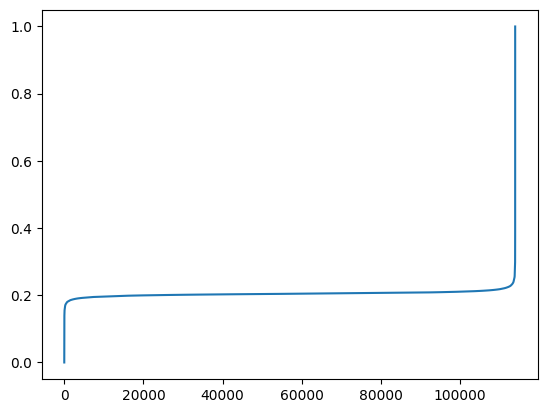

In [13]:
encoder.print_scaler_ranges()

values = []
for dataset in train_datasets.values():
    values.extend(encoder.encode(dataset)[:,0])
    
print(f"{len(values)} values")
print(f"Mean: {np.mean(values)}")
print(f"Stdev: {np.std(values)}")
    
t = [i for i in range(len(values))]
plt.plot(t, sorted(values))
plt.show()

In [14]:
batch = 2048
epochs = 50

model = make_model(days_in, days_out)
weights = calculate_weights(train_x, train_y, 0.02)
early_stopping = EarlyStopping(monitor='val_loss', patience=epochs//5, restore_best_weights=True)
history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch, validation_data=(test_x, test_y), \
                    verbose=1, shuffle=True, callbacks=[early_stopping], sample_weight=weights)

print("\nEvaluation:")
model.evaluate(validation_x, validation_y, batch_size=batch)

Epoch 1/50
35/35 [==============================] - 16s 172ms/step - loss: 0.1110 - val_loss: 0.2013
Epoch 2/50
35/35 [==============================] - 5s 148ms/step - loss: 0.0247 - val_loss: 0.1308
Epoch 3/50
35/35 [==============================] - 5s 146ms/step - loss: 0.0155 - val_loss: 0.0851
Epoch 4/50
35/35 [==============================] - 5s 148ms/step - loss: 0.0142 - val_loss: 0.0666
Epoch 5/50
35/35 [==============================] - 5s 149ms/step - loss: 0.0138 - val_loss: 0.0443
Epoch 6/50
35/35 [==============================] - 5s 147ms/step - loss: 0.0144 - val_loss: 0.0329
Epoch 7/50
35/35 [==============================] - 5s 146ms/step - loss: 0.0135 - val_loss: 0.0313
Epoch 8/50
35/35 [==============================] - 5s 147ms/step - loss: 0.0121 - val_loss: 0.0254
Epoch 9/50
35/35 [==============================] - 5s 147ms/step - loss: 0.0102 - val_loss: 0.0187
Epoch 10/50
35/35 [==============================] - 5s 151ms/step - loss: 0.0122 - val_loss: 0.020

0.009968730621039867

In [15]:
def evaluate_performance(model_creator, days_in, days_out, number_of_datasets=15, epochs=30, verbose=False):
    train_datasets, validation_datasets = load_datasets(number_of_datasets)
    train_x, train_y, test_x, test_y, encoder = datasets_to_training_data(train_datasets, days_in, days_out)
    validation_x, validation_y = datasets_to_validation_data(validation_datasets, days_in, days_out, encoder)

    model = model_creator(days_in, days_out)
    weights = calculate_weights(train_x, train_y, 0.02)

    batch_size = 2048
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, \
                        validation_data=(test_x, test_y), verbose=(1 if verbose else 0), \
                        shuffle=True, callbacks=[EarlyStopping(monitor='val_loss', patience=epochs//5, \
                                                               restore_best_weights=True)], \
                        sample_weight=weights)

    evaluation = model.evaluate(validation_x, validation_y, batch_size=batch_size, verbose=(1 if verbose else 0))
    return evaluation, history

In [16]:
evaluate_performance(make_model, days_in, days_out, number_of_datasets=10)

(0.04373808577656746, <keras.callbacks.History at 0x7c7af042f8e0>)

In [17]:
commission = 0.005
volatility = 0.0005

class Assets:
    def __init__(self, tokens, initial=100, commission=commission):
        self._initial = initial
        self.commission = commission
        self.stocks = {token: 0 for token in tokens}
        self.stocks["money"] = initial
        
    def buy(self, token, stock_amount, price):
        if token not in self.stocks:
            raise Exception(f"unknown token '{token}'")
        
        self.stocks["money"] -= stock_amount * price
        self.stocks[token] += stock_amount * (1-self.commission)
        
    def sell(self, token, stock_amount, price):
        if token not in self.stocks:
            raise Exception(f"unknown token '{token}'")
        
        self.stocks["money"] += stock_amount * price * (1-self.commission)
        self.stocks[token] -= stock_amount
        
    def current_return(self, prices_dict):
        value = sum((amount * prices_dict[token] if token != "money" else amount) for token, amount in self.stocks.items())
        return value / self._initial - 1
    
    def held(self):
        for token, value in self.stocks.items():
            if value > 0 and token != "money":
                yield token
                
    def money(self):
        return self.stocks["money"]
    
class Action:
    volatility = volatility
    
    def __init__(self, action, token, amount, req_price=None):
        self.action = action
        self.token = token
        self.amount = amount
        self.price = req_price
        self.executed = False
        
    def apply(self, assets, high, low):
        if self.action == "buy":
            if low * (1+Action.volatility) >= self.price:
                return
            assets.buy(self.token, self.amount, low)
            self.executed = True
        elif self.action == "market buy":
            price = random.uniform(low, high)
            assets.buy(self.token, self.amount / price, price)
            self.executed = True
        elif self.action == "sell":
            if high * (1-Action.volatility) <= self.price:
                return
            assets.sell(self.token, self.amount, high)
            self.executed = True
        elif self.action == "market sell":
            assets.sell(self.token, self.amount, random.uniform(low, high))
            self.executed = True
            
    def __str__(self):
        return f"Action(action='{self.action}', token='{self.token}', " + \
            f"amount={self.amount}, price={self.price}, executed={self.executed})"

In [18]:
class Prediction:
    class Token:
        def __init__(self, result):
            self.close_changes = result[:, 0]
            self.high_changes = result[:, 1]
            self.low_changes = result[:, 2]
    
    def __init__(self, decoded_results_dict):
        self.results = {token: self.Token(result) for token, result in decoded_results_dict.items()}

In [19]:
class HoldStrategy:
    class HistoryEntry:
        def __init__(self, prediction, evaluations, desired, held, actions):
            self.predictions = prediction
            self.evaluations = evaluations
            self.desired = desired
            self.held = held
            self.actions = actions
    
    class Evaluation:
        def __init__(self, token_name, token):
            """
            token_name: stock token
            token: Token object
            """
            self.name = token_name
            self.token = token
            
            acc_close_changes = [
                i for i in accumulate(token.close_changes, lambda v, n: v*(1+n), initial=1)
            ][1:]
            self.growth_rate = max(change/(days+1) for days, change in enumerate(acc_close_changes))
            
        def __str__(self):
            return f"'{self.name}': {self.growth_rate}"
    
    def __init__(self, skew=0.1):
        self._skew=skew
        self.history = []
    
    def apply(self, prediction, assets):
        """
        prediction: Prediction object
        assets: Assets object
        """
        
        evaluations = [self.Evaluation(name, token) for name, token in prediction.results.items()]
        
        held = assets.held()
        evaluations.sort(
            key=lambda e: e.growth_rate*(1+self._skew) if (e.name in held) else e.growth_rate,
            reverse=True
        )
        
        
        desired = [evaluation.name for evaluation, _ in zip(evaluations, range(3))]
        actions = []
        for token in held:
            if token in desired:
                continue
            actions.append(Action("market sell", token, assets.stocks[token]))
            
        if assets.money() > 1e-2:
            to_buy = desired
            for token in held:
                to_buy.remove(token)
            for token in to_buy:
                actions.append(Action("market buy", token, assets.money()/len(to_buy)))
                
        self.history.append(HoldStrategy.HistoryEntry(prediction, evaluations, desired, held, actions))
                
        return actions

In [20]:
def simulate_parallel(datasets, encoder, model, strategy=None):
    assets = Assets([key for key in datasets.keys()], commission=commission)
    features = {token: series_to_lstm_inputs(encoder.encode(dataset), days_in, days_out)[0] for token, dataset in datasets.items()}
    if strategy is None:
        strategy = HoldStrategy(skew=0.1)
    days = min(len(f) for _, f in features.items())
    for i in range(days):
        if int(i/days*100) > int((i-1)/days*100):
            print(f"{int(i/days*100)}% done...")
        
        results = {token: encoder.decode(model.predict(feature[i:i+1], verbose=0)) for token, feature in features.items()}
        actions = strategy.apply(Prediction(results), assets)
        for action in actions:
            action.apply(assets, datasets[action.token]['High'].iloc[i+days_in+1], datasets[action.token]['Low'].iloc[i+days_in+1])
        yield assets.current_return({token: dataset['Close'].iloc[i+days_in+1] for token, dataset in datasets.items()})
        
    print("Positions:")
    for token, value in assets.stocks.items():
        if value == 0:
            continue
        print(f"{token}: {value}")

In [21]:
if False:
    strategy = HoldStrategy(skew=0)
    simulation = [r for r in simulate_parallel(validation_datasets, encoder, model, strategy)]
    print(f"Return: {simulation[-1]*100}%")

    t = [r for r in range(len(simulation))]
    plt.plot(t, simulation)

In [22]:
model.save("model.h5", save_format="h5")
serialize_encoder(encoder, "config.json")
os.listdir("/kaggle/working")

['model.tf', '.virtual_documents', 'model.h5']

In [24]:
# TODO:
# Change scaler
#   Scaled data should be more equally distributed (maybe just scale 10th and 90th percentile to 0-1?)
#   Volume should be logaritmic
#   Implement distribution verification in nice way in functions
# Higher-level metrics as input
#   Include info about other tokens in some way (general market trend?)